# Module - 1
# Classification of Solubility of Organic Compounds using Decision Trees

## Importing required libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import pickle
import os
import requests
from io import StringIO

warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Chemistry
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")

All libraries imported successfully!
PyTorch version: 2.2.0+cu121
Device available: GPU


## Loading ESOL dataset

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']
Dataset shape: (1128, 3)
LogS range: -11.60 to 1.58

Sample data:
                                              SMILES  LogS  \
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77   
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30   
2                               CC(C)=CCCC(C)=CC(=O) -2.06   
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87   
4                                            c1ccsc1 -1.33   

   ESol_Predicted_LogS  
0               -0.974  
1               -2.885  
2               -2.579  
3               -6.618  
4               -2.232  


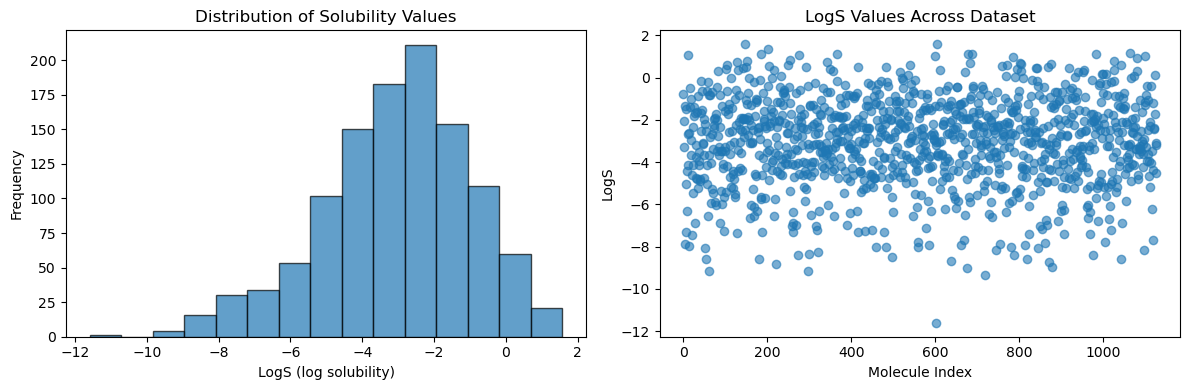

In [2]:

def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS','ESol_Predicted_LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()
print(f"Dataset shape: {df.shape}")
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")
print("\nSample data:")
print(df.head())

# Visualize distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

## Errors in ESol predicted values

The authors of the paper used a linear regression model to predict LogS values.

In [3]:
#Errors in model used by authors of ESol paper
ESol_mse = mean_squared_error(df['LogS'], df['ESol_Predicted_LogS'])
print(f"ESOL MSE: {ESol_mse:.4f}")
ESol_mae = mean_absolute_error(df['LogS'], df['ESol_Predicted_LogS'])
print(f"ESOL MAE: {ESol_mae:.4f}")
ESol_r2 = r2_score(df['LogS'], df['ESol_Predicted_LogS'])
print(f"ESOL R^2: {ESol_r2:.4f}")

ESOL MSE: 0.8283
ESOL MAE: 0.6979
ESOL R^2: 0.8114


## Calculating molecular properties (input features) using RDKit and SMILES string

In [4]:
# Basic descriptors available in all RDKit versions
descriptor_functions = [
    ('MolWt', Descriptors.MolWt),
    ('LogP', Descriptors.MolLogP),
    ('NumHDonors', Descriptors.NumHDonors),
    ('NumHAcceptors', Descriptors.NumHAcceptors),
    ('TPSA', Descriptors.TPSA),
    ('NumRotatableBonds', Descriptors.NumRotatableBonds),
]
def calculate_molecular_descriptors(smiles_list,descriptor_functions=None):
    """Calculate traditional molecular descriptors 
    returns a DataFrame with descriptors for each SMILES string"""
    descriptors = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            descriptors.append([0] * len(descriptor_functions))
            continue

        mol_descriptors = []
        for name, func in descriptor_functions:
            try:
                value = func(mol)
                mol_descriptors.append(value if value is not None else 0)
            except:
                mol_descriptors.append(0)
        # Now we calculate some additional descriptors, like aromatic proportion(fraction of heavy atoms that are aromatic) 
        # and non-carbon proportion(fraction of heavy atoms that are not carbon)
        aromatic_atoms_count = 0
        for atom in mol.GetAtoms():
            if atom.GetIsAromatic():
                aromatic_atoms_count += 1
        heavy_atoms_count = mol.GetNumHeavyAtoms()
        aromatic_proportion = aromatic_atoms_count / heavy_atoms_count if heavy_atoms_count > 0 else 0  
        mol_descriptors.append(aromatic_proportion)
        carbon_count = 0
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 6:
                carbon_count += 1
        non_carbon_proportion = (heavy_atoms_count - carbon_count) / heavy_atoms_count if heavy_atoms_count > 0 else 0
        mol_descriptors.append(non_carbon_proportion)

        descriptors.append(mol_descriptors)
    return pd.DataFrame(descriptors,columns=[name for name, _ in descriptor_functions] + ['AromaticProportion', 'NonCarbonProportion']) 

# Training a classifier (where classes are soluble and insoluble) using decision trees

## Deciding on a threshold
For training a classifier, we need to set a threshold value of solubility over which the molecule will be classified as soluble and below which it will be classified as insoluble. 2 possible candidate values are 10 uG/mL or 50 uG/mL. (Sun H, Shah P, Nguyen K, Yu KR, Kerns E, Kabir M, Wang Y, Xu X. Predictive models of aqueous solubility of organic compounds built on A large dataset of high integrity.)

To decide on that value , lets do a bit of analysis of our dataset.

First,we convert logS --> S(mol/L) --> S(g/L)


In [5]:
df['S(in mol/L)'] = np.power(10,df['LogS']) #log in base 10 in chemistry
weights = []
for smile in df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    mol_wt = Descriptors.MolWt(mol)
    weights.append(mol_wt)
df['mol_wt']=weights
df['S(in g/L)']=df['S(in mol/L)']*df['mol_wt']

## Analysing distribution of S (in g/L)

In [6]:
print(f"mean S : {np.mean(df["S(in g/L)"])}")
print(f"std_dev S : {np.std(df["S(in g/L)"])}")
print(f"median S : {np.median(df["S(in g/L)"])}")
print(f"Fraction of moleculess with S less than 0.01 :  {np.mean(df["S(in g/L)"] < 0.01)}")
print(f"Fraction of moleculess with S less than 0.05 :  {np.mean(df["S(in g/L)"] < 0.05)}")



mean S : 39.4439457174898
std_dev S : 210.11273599723103
median S : 0.23663219919698467
Fraction of moleculess with S less than 0.01 :  0.24113475177304963
Fraction of moleculess with S less than 0.05 :  0.35815602836879434


As molecules in our distribution are more evenly distributed around threshold of 0.05 g/L (or 50 uG/mL), we will take that as threshold of solubility.

In [7]:
df['is_soluble']=(df['S(in g/L)'] < 0.05).astype(int) # 0 if insoluble, 1 if soluble
#save the dataframe to a pickle file
df.to_pickle('esol.pkl')
df

,SMILES,LogS,ESol_Predicted_LogS,S(in mol/L),mol_wt,S(in g/L),is_soluble
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,-0.974,1.698244e-01,457.432,77.683099,0
1,Cc1occc1C(=O)Nc2ccccc2,-3.300,-2.885,5.011872e-04,201.225,0.100851,0
2,CC(C)=CCCC(C)=CC(=O),-2.060,-2.579,8.709636e-03,152.237,1.325929,0
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,-6.618,1.348963e-08,278.354,0.000004,1
4,c1ccsc1,-1.330,-2.232,4.677351e-02,84.143,3.935664,0
...,...,...,...,...,...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710,-2.608,1.949845e-02,197.381,3.848623,0
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,-0.908,1.276439e+00,219.266,279.879632,0
1125,CCSCCSP(=S)(OC)OC,-3.091,-3.323,8.109611e-04,246.359,0.199788,0
1126,CCC(C)C,-3.180,-2.245,6.606934e-04,72.151,0.047670,1


In [8]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['SMILES'].values, df['is_soluble'].values,
    test_size=0.2, random_state=42
)

In [9]:
# Calculate descriptors
X_train_desc = calculate_molecular_descriptors(X_train,descriptor_functions)
X_test_desc = calculate_molecular_descriptors(X_test,descriptor_functions)
print("X_train_desc keys : ",X_train_desc.columns.tolist())
# Scale descriptors
scaler = StandardScaler()
X_train_desc_scaled = scaler.fit_transform(X_train_desc)
X_test_desc_scaled = scaler.transform(X_test_desc)

X_train_desc keys :  ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'AromaticProportion', 'NonCarbonProportion']


### We will be using DecisionTreeClassifier from sklearn.

We have to set a max_depth as decision trees are often prone to overfitting.

Test Accuracy (for max_depth : 1) : 0.8716814159292036  |  Train Accuracy (for max_depth : 1) : 0.8780487804878049
Test Accuracy (for max_depth : 2) : 0.8716814159292036  |  Train Accuracy (for max_depth : 2) : 0.8780487804878049
Test Accuracy (for max_depth : 3) : 0.8805309734513275  |  Train Accuracy (for max_depth : 3) : 0.9024390243902439
Test Accuracy (for max_depth : 4) : 0.8938053097345132  |  Train Accuracy (for max_depth : 4) : 0.917960088691796
Test Accuracy (for max_depth : 5) : 0.8805309734513275  |  Train Accuracy (for max_depth : 5) : 0.9323725055432373
Test Accuracy (for max_depth : 6) : 0.8893805309734514  |  Train Accuracy (for max_depth : 6) : 0.9512195121951219
Test Accuracy (for max_depth : 7) : 0.8849557522123894  |  Train Accuracy (for max_depth : 7) : 0.9656319290465631
Test Accuracy (for max_depth : 8) : 0.8849557522123894  |  Train Accuracy (for max_depth : 8) : 0.9767184035476718
Test Accuracy (for max_depth : 9) : 0.8849557522123894  |  Train Accuracy (for ma

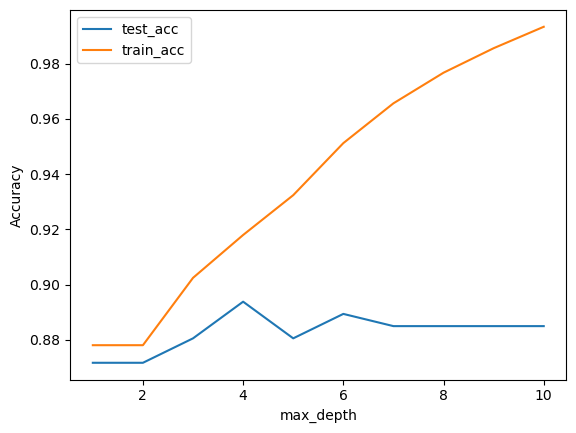

In [10]:
from sklearn.tree import DecisionTreeClassifier
test_acc=[]
train_acc = []
# Train and evaluate Decision Tree model with varying max_depth
for i in range(1,11):
    tree_model = DecisionTreeClassifier(criterion='gini',max_depth=i,random_state=1)
    tree_model.fit(X_train_desc, y_train)
    y_pred = tree_model.predict(X_test_desc)
    print(f"Test Accuracy (for max_depth : {i}) : {np.mean(y_pred==y_test)}",end="  |  ")
    test_acc.append(np.mean(y_pred==y_test))
    y_pred = tree_model.predict(X_train_desc)
    print(f"Train Accuracy (for max_depth : {i}) : {np.mean(y_pred==y_train)}")
    train_acc.append(np.mean(y_pred==y_train))
plt.plot(np.arange(1,11,1),test_acc,label="test_acc")
plt.plot(np.arange(1,11,1),train_acc,label="train_acc")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Clearly, after max_depth = 4, the decision tree starts to overfit. (as test accuracy << train eaccuracy)

Hence, we set max_depth = 4 and evaluate the model on test set using metrics like accuracy , precision , recall and f1 score.

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1 Score = 2 / ((1/Precision) + (1/Recall)) --> H.M of Precision and Recall

Train Accuracy (for max_depth : 4) : 0.917960088691796
Test Accuracy (for max_depth : 4) : 0.8938053097345132  | Precision: 0.8800, Recall: 0.8148
Confusion Matrix:


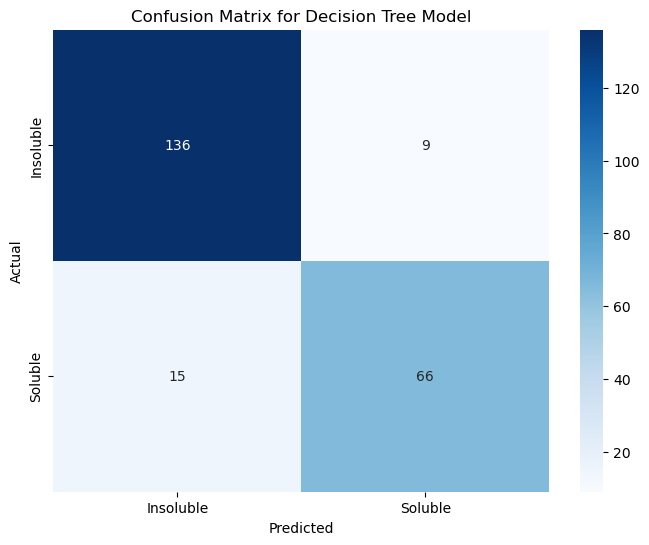

In [11]:
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4,random_state=1)
tree_model.fit(X_train_desc, y_train)
y_pred = tree_model.predict(X_train_desc)
print(f"Train Accuracy (for max_depth : 4) : {np.mean(y_pred==y_train)}")
y_pred = tree_model.predict(X_test_desc)
print(f"Test Accuracy (for max_depth : 4) : {np.mean(y_pred==y_test)} ",end = " | ")
#Calculate Precision And Recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
#Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Insoluble', 'Soluble'], yticklabels=['Insoluble', 'Soluble'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()


In [12]:
#Plot the decision tree
from sklearn import tree
plt.figure(figsize=(100, 100))
tree.plot_tree(tree_model,feature_names=["MolWt",'LogP','NumHDonors','NumHAcceptors','TPSA','NumRotatableBonds','AromaticProportion', 'NonCarbonProportion'],filled=True)
plt.show()

Now,in our tree a majority of the early splits are based on LogP. This could be because LogP and LogS are closely related properties. Now, lets try a training a model without using LogP as a feature to understand how other properties affect LogS.

X_train_desc keys :  ['MolWt', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'AromaticProportion', 'NonCarbonProportion']
Train Accuracy (for max_depth : 4) : 0.8802660753880266
Test Accuracy (for max_depth : 4) : 0.8761061946902655  | Precision: 0.8442, Recall: 0.8025
Confusion Matrix:


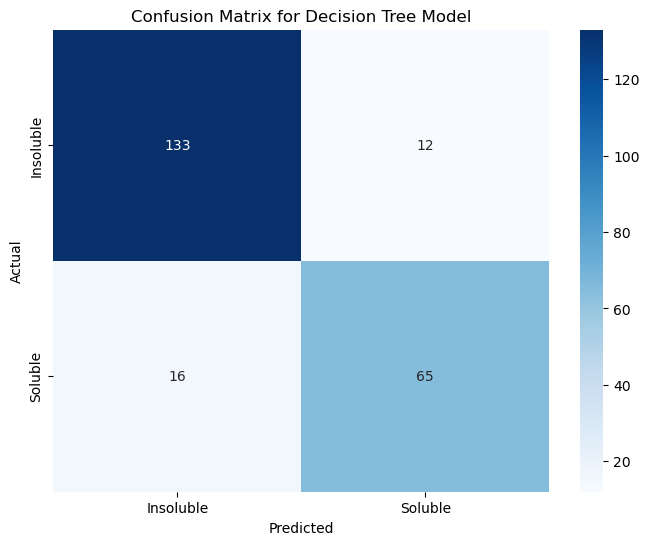

In [14]:
descriptor_functions = [
    ('MolWt', Descriptors.MolWt),
    ('NumHDonors', Descriptors.NumHDonors),
    ('NumHAcceptors', Descriptors.NumHAcceptors),
    ('TPSA', Descriptors.TPSA),
    ('NumRotatableBonds', Descriptors.NumRotatableBonds),
]

# Calculate descriptors
X_train_desc = calculate_molecular_descriptors(X_train,descriptor_functions)
X_test_desc = calculate_molecular_descriptors(X_test,descriptor_functions)
print("X_train_desc keys : ",X_train_desc.columns.tolist())

# Scale descriptors
scaler = StandardScaler()
X_train_desc_scaled = scaler.fit_transform(X_train_desc)
X_test_desc_scaled = scaler.transform(X_test_desc)

# Train and evaluate Decision Tree model
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4,random_state=1)
tree_model.fit(X_train_desc, y_train)
y_pred = tree_model.predict(X_train_desc)
print(f"Train Accuracy (for max_depth : 4) : {np.mean(y_pred==y_train)}")

#Evaluating this model on test set using metrics like accuracy , precision , recall and f1 score.
y_pred = tree_model.predict(X_test_desc)
print(f"Test Accuracy (for max_depth : 4) : {np.mean(y_pred==y_test)} ",end = " | ")

#Calculate Precision And Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

#Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Insoluble', 'Soluble'], yticklabels=['Insoluble', 'Soluble'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

#Plot the decision tree
plt.figure(figsize=(100, 100))
tree.plot_tree(tree_model,feature_names=["MolWt",'NumHDonors','NumHAcceptors','TPSA','NumRotatableBonds','AromaticProportion', 'NonCarbonProportion'],filled=True)
plt.show()







We get nearly identical performance if we remove LogP as one of the features, but the splits in the decision trees are different.

# Using Random Forest Classifier

In random forest, an ensemble of decision trees are used. For each tree, we select n samples from dataset(with replacement) and at each splitting step, select some random subset of features for splitting(based on which gives max Information Gain).

Hence, the different trees use different splits and hence model is less prone to overfitting.

We can use majority vote to select the final prediction.

In [15]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['SMILES'].values, df['is_soluble'].values,
    test_size=0.2, random_state=42
)
descriptor_functions = [
    ('MolWt', Descriptors.MolWt),
    ('LogP', Descriptors.MolLogP),
    ('NumHDonors', Descriptors.NumHDonors),
    ('NumHAcceptors', Descriptors.NumHAcceptors),
    ('TPSA', Descriptors.TPSA),
    ('NumRotatableBonds', Descriptors.NumRotatableBonds),
]
# Calculate descriptors
X_train_desc = calculate_molecular_descriptors(X_train,descriptor_functions)
X_test_desc = calculate_molecular_descriptors(X_test,descriptor_functions)
print("X_train_desc keys : ",X_train_desc.columns.tolist())
# Scale descriptors
scaler = StandardScaler()
X_train_desc_scaled = scaler.fit_transform(X_train_desc)
X_test_desc_scaled = scaler.transform(X_test_desc)

X_train_desc keys :  ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'AromaticProportion', 'NonCarbonProportion']


Test accuracy for n_estimators = 10 : 0.8761061946902655 | Train accuracy for n_estimators = 10 : 0.9866962305986696
Test accuracy for n_estimators = 25 : 0.9070796460176991 | Train accuracy for n_estimators = 25 : 0.9955654101995566
Test accuracy for n_estimators = 50 : 0.8982300884955752 | Train accuracy for n_estimators = 50 : 0.9977827050997783
Test accuracy for n_estimators = 100 : 0.8938053097345132 | Train accuracy for n_estimators = 100 : 0.9977827050997783
Test accuracy for n_estimators = 1000 : 0.8982300884955752 | Train accuracy for n_estimators = 1000 : 0.9977827050997783


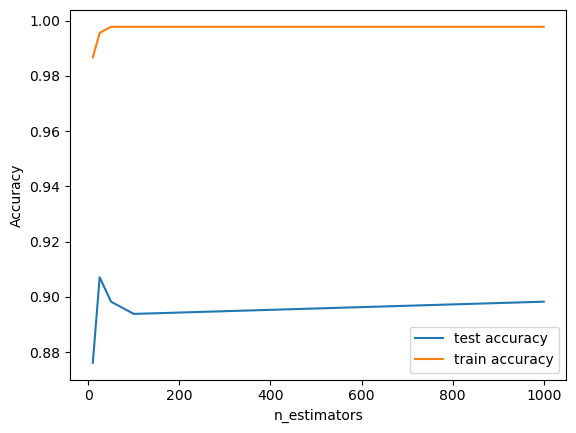

In [16]:
from sklearn.ensemble import RandomForestClassifier
test_acc=[]
train_acc=[]
# Train and evaluate Random Forest model with varying n_estimators(n_estimators = number of trees in the forest)
for i in [10,25,50,100,1000]:
    forest = RandomForestClassifier(n_estimators=i,random_state=1,n_jobs=2,max_features='sqrt')
    forest.fit(X_train_desc, y_train)
    y_pred = forest.predict(X_test_desc)
    print(f"Test accuracy for n_estimators = {i} : {np.mean(y_pred==y_test)}",end = " | ")
    test_acc.append(np.mean(y_pred==y_test))
    y_pred = forest.predict(X_train_desc)
    print(f"Train accuracy for n_estimators = {i} : {np.mean(y_pred==y_train)}")
    train_acc.append(np.mean(y_pred==y_train))
plt.plot([10,25,50,100,1000],test_acc,label="test accuracy")
plt.plot([10,25,50,100,1000],train_acc,label="train accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As test accuracy decreases after n_estimators = 25, we can put n_estimators =25. (As for greater values, we are overfitting).

Train accuracy for n_estimators = 25 : 0.9955654101995566
Test Accuracy (for n_estimators = 25) : 0.9070796460176991 
Precision: 0.9054
,Recall: 0.8272
Confusion Matrix:


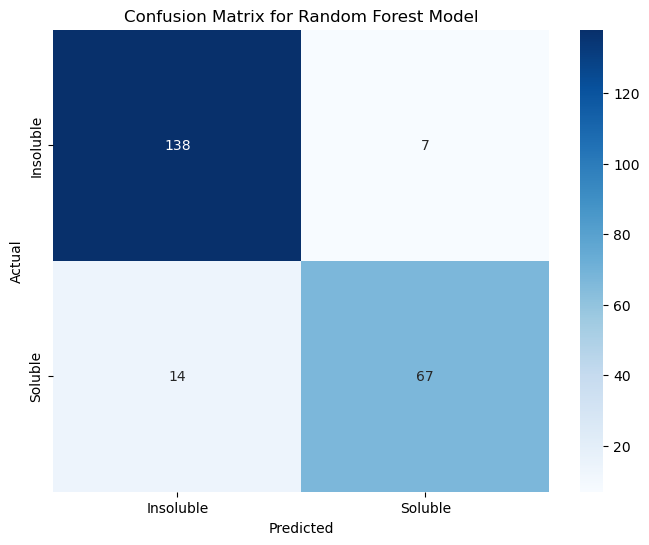

In [18]:
#Evaluating the model with n_estimators = 25
forest = RandomForestClassifier(n_estimators=25,random_state=1,n_jobs=2)
forest.fit(X_train_desc, y_train)
y_pred = forest.predict(X_train_desc)
print(f"Train accuracy for n_estimators = 25 : {np.mean(y_pred==y_train)}")
y_pred = forest.predict(X_test_desc)

#Evaluating this model on test set using metrics like accuracy , precision , recall and f1 score.
y_pred = forest.predict(X_test_desc)
print(f"Test Accuracy (for n_estimators = 25) : {np.mean(y_pred==y_test)} ")

#Calculate Precision And Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}\n,Recall: {recall:.4f}")

#Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Insoluble', 'Soluble'], yticklabels=['Insoluble', 'Soluble'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()



We get slightly better performance in Random Forest, although it is still overfitting. 

Things to try : 

i) XGBoost model

ii) k-NN model

iii) Try running on larger datasets(AqSoldb)